In [3]:
import torch
import numpy as np
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", "FutureWarning")
plt.style.use("dark_background")

# дополнительные импорты для задачи

import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchmetrics import Accuracy
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from collections import Counter
from tqdm.autonotebook import tqdm

## 1. Создаем данные

In [4]:
x_np = np.random.uniform(-10,10,(20000,1))
y_np = np.random.uniform(-10,10,(20000,1))

In [5]:
z_np = np.sin(x_np * 2 ** y_np) * np.exp(-(2 * x_np + y_np)**2)

In [6]:
import numpy as geek

In [7]:
x_y_np = geek.concatenate((x_np, y_np), axis=1)

In [11]:
x_y_np

array([[-8.77981608,  7.30752578],
       [ 5.99507143,  4.59090496],
       [-7.55364826,  6.52442349],
       ...,
       [ 7.93784908, -3.97811461],
       [ 1.61561928,  7.14816666],
       [-6.15612244, -9.23450849]])

In [83]:
y_np

array([[ 7.30752578],
       [ 4.59090496],
       [ 6.52442349],
       ...,
       [-3.97811461],
       [ 7.14816666],
       [-9.23450849]])

In [12]:
# Подготавливаем входной тензор (x, x^2, x^3) который будет поступать в сеть:
#p = np.array([1, 2, 3])     # степени полинома
p = [1,2]
xx = np.power(x_np, p)     # возводим входной вектор x в степени p

In [13]:
xx

array([[ 6.73063475e-02,  4.53014441e-03],
       [-9.51237181e+00,  9.04852174e+01],
       [-7.53696886e+00,  5.68058996e+01],
       ...,
       [ 3.47491570e+00,  1.20750391e+01],
       [ 9.36806091e+00,  8.77605652e+01],
       [-3.00147050e+00,  9.00882515e+00]])

In [14]:
yy = np.power(y_np, p)
yy

array([[ 3.4370705 , 11.81345363],
       [-8.71030413, 75.86939801],
       [ 6.00129231, 36.01550937],
       ...,
       [ 6.01383125, 36.16616629],
       [-0.53639343,  0.28771791],
       [-8.97187321, 80.49450886]])

In [15]:
x_y_np = geek.concatenate((xx, yy), axis=1)
x_y_np

array([[ 6.73063475e-02,  4.53014441e-03,  3.43707050e+00,
         1.18134536e+01],
       [-9.51237181e+00,  9.04852174e+01, -8.71030413e+00,
         7.58693980e+01],
       [-7.53696886e+00,  5.68058996e+01,  6.00129231e+00,
         3.60155094e+01],
       ...,
       [ 3.47491570e+00,  1.20750391e+01,  6.01383125e+00,
         3.61661663e+01],
       [ 9.36806091e+00,  8.77605652e+01, -5.36393429e-01,
         2.87717911e-01],
       [-3.00147050e+00,  9.00882515e+00, -8.97187321e+00,
         8.04945089e+01]])

## Делим данные на train, test,  val

In [16]:
xy_train, xy_test_val, z_train, z_test_val = train_test_split(x_y_np, z_np, test_size=0.3,  random_state=42)

In [155]:
z_train


array([[-1.02981190e-021],
       [-6.43616514e-149],
       [ 8.39721819e-014],
       ...,
       [ 1.85574990e-001],
       [-1.71519324e-078],
       [ 1.01609772e-167]])

array([[<Axes: title={'center': '0'}>]], dtype=object)

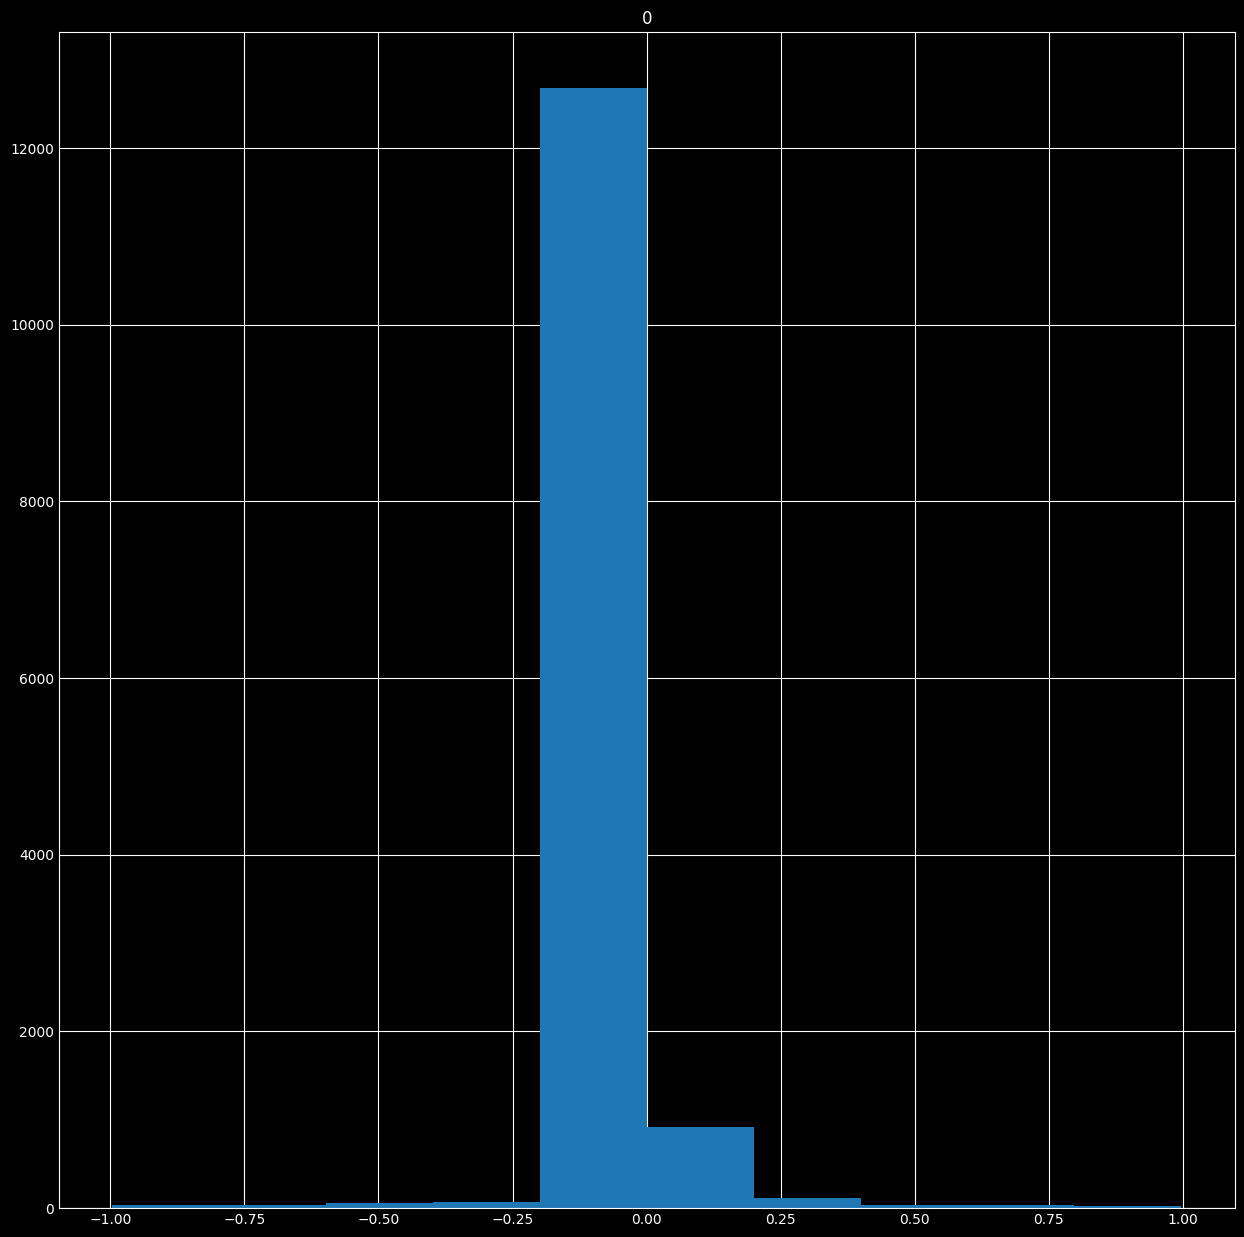

In [156]:
import pandas as pd
df1 = pd.DataFrame(z_train)
df1.hist()

In [164]:
print(f'{z_train[1]}')

[-6.43616514e-149]


In [17]:
xy_test, xy_val, z_test, z_val = train_test_split(xy_test_val, z_test_val, test_size=0.5,  random_state=42)

In [121]:
xy_test

array([[ 9.76005653e+00,  7.85567556e-01, -8.13758358e+01],
       [ 4.87548525e+00, -3.34059158e+00, -4.06500398e+01],
       [ 9.17147313e+00,  1.80882873e+00, -7.64684393e+01],
       ...,
       [-7.95608298e-02, -5.11148734e+00,  6.63349540e-01],
       [ 6.29077030e+00, -5.80372308e+00, -5.24501768e+01],
       [ 7.62306741e+00,  8.86366190e+00, -6.35583902e+01]])

In [22]:
xy_test[:,1]

array([-2.98905049, -2.49447466, -5.87056318, ...,  0.87734415,
        4.73881591, -8.93044359])

In [23]:
xy_test[:,0]

array([ 4.92777476, -1.30174336, -6.48581686, ...,  6.67740707,
        7.42273709,  2.3705457 ])

### конвертируем данные в тензор


In [18]:
train_XY = torch.from_numpy(xy_train).to(torch.float32)
train_Z = torch.from_numpy(z_train).type_as(train_XY)
val_XY = torch.from_numpy(xy_val).to(torch.float32)
val_Z = torch.from_numpy(z_val).type_as(val_XY)

In [25]:
test_XY = torch.from_numpy(xy_test).to(torch.float32)
test_Z = torch.from_numpy(z_test).type_as(test_XY)

Подготовка данных к обучению

In [26]:
BATCH = 100
# создали датасеты
train_dataset = TensorDataset(train_XY, train_Z)
val_dataset = TensorDataset(val_XY, val_Z)
test_dataset = TensorDataset(test_XY, test_Z)
# создаем загрузчики
train_loader = DataLoader(train_dataset, batch_size=BATCH)
val_loader = DataLoader(val_dataset, batch_size=BATCH)
test_loader = DataLoader(test_dataset, batch_size=BATCH)

In [23]:
DEVICE = "cpu"

## Линейная модель аппроксимирующей функции

z = xW1 + yW2 + b

In [32]:
class MyLinearRegression(nn.Module):
  # 1ый обязательный метод
  def __init__(self, in_features, out_features):
    super().__init__() # обязательно
    self.W_1 = nn.Parameter(torch.randn((in_features, out_features),
                                      requires_grad=True)
    )
    self.W_2 = nn.Parameter(torch.randn((in_features, out_features),
                                      requires_grad=True)
    )
    self.b = nn.Parameter(torch.ones(out_features),
                                      requires_grad=True)

  # 2ой обязательный метод
  def forward(self, x):
    x = x[:0] @ self.W_1
    y = x[:1] @ self.W_2
    z_rec = x + y + self.b
    return z_rec

In [ ]:
model = torch.nn.Sequential(
    torch.nn.Linear(3, 1),      # линейный слой из одного нейрона и трех входов (весов)
    torch.nn.Flatten(0, 1)      # представляем результат в виде вектора
)

In [20]:
# как мы будем учиться работать с pyTorch
class NNsuperTest(nn.Module):
  # 1ый обязательный метод
  def __init__(self, in_features, out_features):
    super().__init__() # обязательно
    #   self.linear = nn.Sequential(
    #                     nn.Linear(2, 4),
    #                     nn.Dropout(p=.5),
    #                     activation,
    #                     nn.Linear(4, 1)
    # )
    self.lin_linear_1 = self.make_layer(in_features, out_features)
    self.flatten = nn.Flatten(0, 1)
  #  self.relu = F.relu

  def make_layer(self, in_f, out_f):
    return nn.Linear(in_f, out_f)

  # 2ой обязательный метод
  def forward(self, x):
    x = self.lin_linear_1(x)
  #  x = self.relu(x)
    x = self.flatten(x)
    return x

In [ ]:
# как мы будем учиться работать с pyTorch
class NNsuper(nn.Module):
  # 1ый обязательный метод
  def __init__(self, in_features, out_features):
    super().__init__() # обязательно
    #   self.linear = nn.Sequential(
    #                     nn.Linear(2, 4),
    #                     nn.Dropout(p=.5),
    #                     activation,
    #                     nn.Linear(4, 1)
    # )
    self.lin_linear_1 = self.make_layer(in_features, in_features * 4)
    self.lin_linear_2 = self.make_layer(in_features * 4, in_features * 2)
    self.lin_linear_3 = self.make_layer(in_features * 2, out_features)
    self.relu = F.relu

  def make_layer(self, in_f, out_f):
    return nn.Linear(in_f, out_f)

  # 2ой обязательный метод
  def forward(self, x):
    x = self.lin_linear_1(x)
    x = self.relu(x)

    x = self.lin_linear_2(x)
    x = self.relu(x)
    x = self.lin_linear_3(x)
    return x

### Обучение

In [21]:
loss_fn = torch.nn.MSELoss(reduction='sum')

In [27]:
# подготовка
# 1. Задать модель - nn.Module
model = NNsuperTest(4, 1)
# 2. Задать функцию потерь - nn.NAME_OF_FUNC
#loss_function = nn.BCEWithLogitsLoss()
# 3. Задать оптимизатор - torch.optim.NAME_OF_OPTIM
#optimizer = torch.optim.SGD(model.parameters(), lr=.042)
# Будем использовать оптимайзер RMSprop из torch.optim:
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3)
# поместить модель и метрику на GPU
model = model.to(DEVICE)
accuracy = Accuracy(task='binary',).to(DEVICE)
# создать вспомогательные списки для данных
# н-р, лосс на каждой итераций
losses_train = []
# н-р, общий лосс
total_loss = []
# н-р, accuracy
acc_val = []
# задать общее количество эпох
MAX_EPOCHS = 200
# для каждой эпохи
for epoch in tqdm(range(MAX_EPOCHS)):
  # для каждой части датасета
  for iteration, (X_batch, y_batch) in enumerate(train_loader):
    # ЭТАП ОБУЧЕНИЯ
    # мы переводим модель в режим обучения
    model.train()
    # ОБНУЛЯЕМ градиенты у оптимизатора
    optimizer.zero_grad()
    #model.zero_grad()
    # пропускам данные через модель
    outputs = model(X_batch.to(DEVICE))
    #print(f'1 outputs = {outputs}')
    # выравняем выходы в одномерный тензор
    #outputs = outputs.view(-1)
    outputs = outputs.unsqueeze(-1)
    #print(f'outputs = {outputs}')
   # print(f'y_batch = {y_batch}')
    # считаем лосс
    #loss = loss_function(outputs, y_batch.to(DEVICE))
    #loss = mse(y_batch.to(DEVICE), outputs)
    loss = loss_fn(outputs, y_batch.to(DEVICE))
    # делаем шаг в обратном направлении
    loss.backward()
    # собираем лоссы
    losses_train.append(loss.detach().cpu().numpy().item())
    # делаем шаг оптимизатора
    optimizer.step()
  # собираем средний лосс
  total_loss.append(np.mean(losses_train))
  # ШАГ ВАЛИДАЦИИ
  for iteration, (X_batch, y_batch) in enumerate(val_loader):
    # режим инференса или валидации, тестирования
    model.eval()
    # обязательно добавить
    with torch.no_grad():
      outputs = model(X_batch.to(DEVICE))
      #outputs = outputs.view(-1)
      outputs = outputs.unsqueeze(-1)
      #loss = loss_function(outputs, y_batch.to(DEVICE))
      loss = loss_fn(outputs, y_batch.to(DEVICE))
      # считаем вероятности
      proba = torch.sigmoid(outputs)
      # ситаем метрику
      batch_acc = accuracy(proba, y_batch.to(torch.int32).to(DEVICE))
      acc_val.append(batch_acc.detach().cpu().numpy().item())

  0%|          | 0/200 [00:00<?, ?it/s]

In [28]:
# Мы можем обратиться к первому слою нашей модели как к первому элементу list:
model.lin_linear_1



Linear(in_features=4, out_features=1, bias=True)

In [29]:
lin_linear_1 = model.lin_linear_1

In [30]:
lin_linear_1.bias.item()

-0.0024150116369128227

In [31]:
lin_linear_1.weight

Parameter containing:
tensor([[ 0.0006, -0.0002, -0.0003, -0.0003]], requires_grad=True)

In [32]:
# Печатаем значения весов этого слоя (это и будут обученный коэффициенты искомого полинома):
print(f'Result: z = {lin_linear_1.bias.item()} + {lin_linear_1.weight[:, 0].item()} * x + {lin_linear_1.weight[:, 1].item()} * y  + {lin_linear_1.weight[:, 2].item()} * x + {lin_linear_1.weight[:, 3].item()} * y')
#print(f'Result: z = {lin_linear_1.bias.item()} + {lin_linear_1.weight[:, 0].item()} * x + {lin_linear_1.weight[:, 1].item()} * y  ')

Result: z = -0.0024150116369128227 + 0.0006416605901904404 * x + -0.0001850745757110417 * y  + -0.0003436296246945858 * x + -0.0002685207291506231 * y


In [34]:
acc = np.mean(acc_val)
print(f"Accuracy линейной модели {acc:.2%}")

Accuracy линейной модели 97.14%


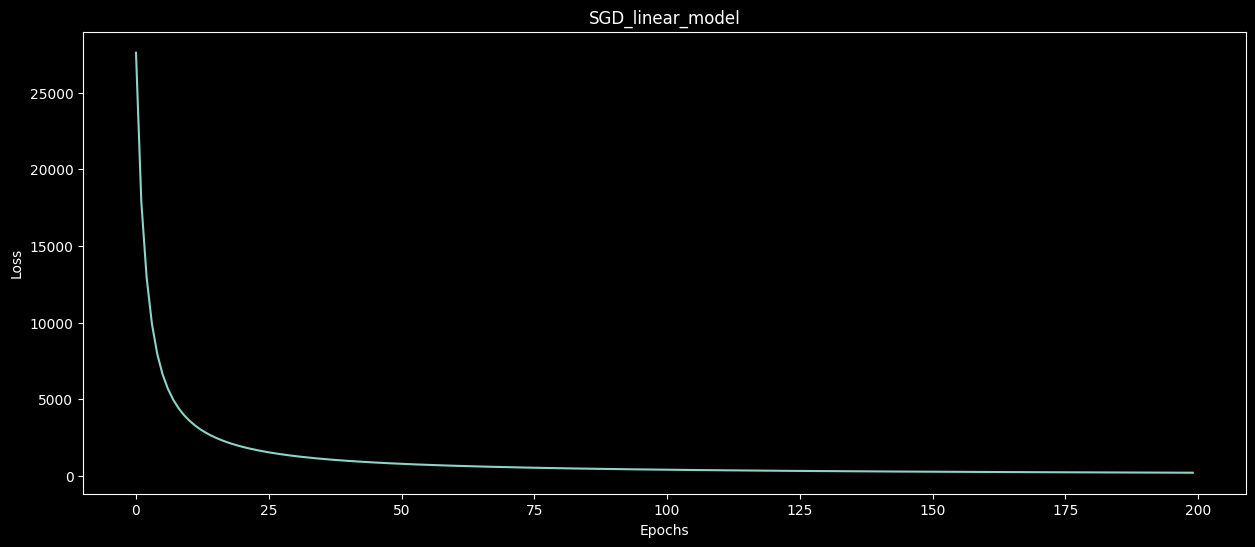

In [47]:
plt.figure(figsize=(15, 6))
plt.plot(range(len(total_loss)),
         total_loss,
         linestyle="-"
         )
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("SGD_linear_model")
plt.show()

In [63]:
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
z_np = np.sin(x_np * 2 ** y_np) * np.exp(-(2 * x_np + y_np)**2)

In [64]:
plt.rcParams["figure.figsize"] = [12, 10]
fig=plt.figure()
ax = Axes3D(fig)

x1 = 2 * np.random.rand(100, 1)
x2 = 5 * np.random.rand(100, 1)

# y = 4 + 3*x_1 + 1*x_2
#y = 4 + 3 * x1 + 1* x2 + np.random.randn(100, 1)

ax.scatter(x_np, y_np, z_np, marker='o')
ax.set_title("Regression problem \n What is y value for new (x1, x2)?")
ax.set_xlabel("x1 (feature)")
ax.set_ylabel("x2 (feature)")
ax.set_zlabel("y (target)")
plt.show();

<Figure size 1200x1000 with 0 Axes>

In [65]:
plt.rcParams["figure.figsize"] = [9, 6]
fig=plt.figure()
ax = Axes3D(fig)

x1 = 2 * np.random.rand(100, 1)
x2 = 5 * np.random.rand(100, 1)

# y = 4 + 3*x_1 + 1*x_2
ys = 4 + 3 * x1 + 1* x2 + np.random.randn(100, 1)

ax.scatter(x1, x2, ys, marker='o')
ax.set_title("Regression problem \n What is y value for new (x1, x2)?")
ax.set_xlabel("x1 (feature)")
ax.set_ylabel("x2 (feature)")
ax.set_zlabel("y (target)")
plt.show();

<Figure size 900x600 with 0 Axes>

In [66]:
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import axes3d
#main code
fig=plt.figure()
ax = fig.gca(projection='3d')
t=np.linspace(0,5*np.pi,501)
ax.plot(np.cos(t),np.sin(t),t)
plt.show()

TypeError: FigureBase.gca() got an unexpected keyword argument 'projection'

<Figure size 900x600 with 0 Axes>

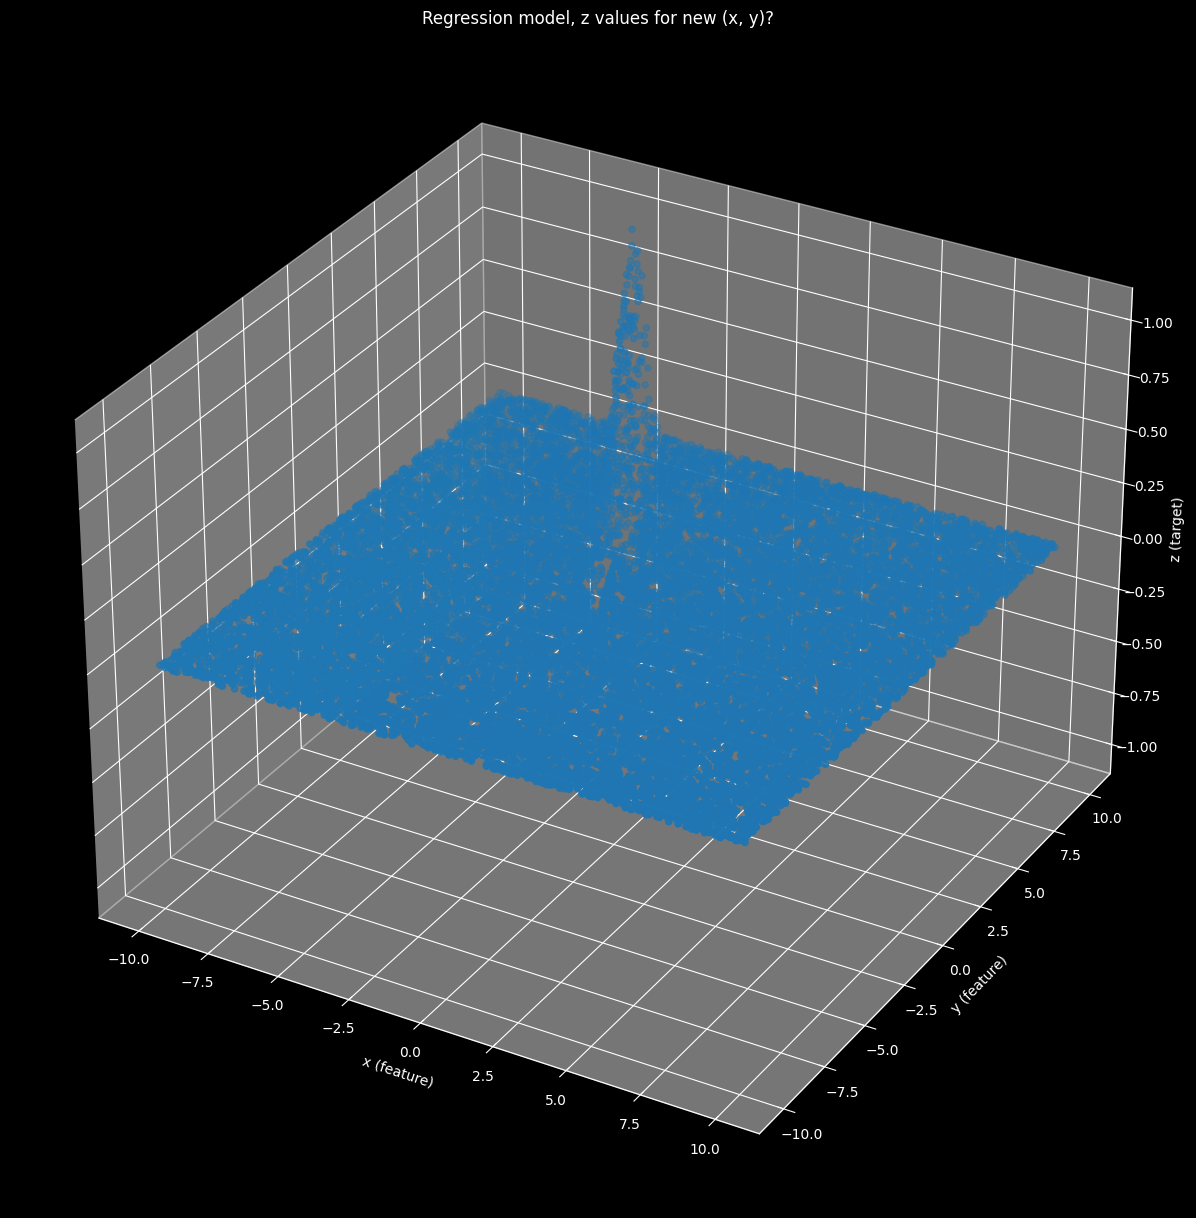

In [75]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams["figure.figsize"] = [12, 12]

#plt.style.use('_mpl-gallery')

# Make data
#np.random.seed(19680801)
#n = 100
#rng = np.random.default_rng()
#xs = rng.uniform(23, 32, n)
#ys = rng.uniform(0, 100, n)
#zs = rng.uniform(-50, -25, n)

# Plot
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
#fig = plt.figure()
#ax = Axes3D(fig)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.scatter(x_np, y_np, z_np, marker='o')

#ax.set(xticklabels=[],
   #    yticklabels=[],
    #   zticklabels=[])

#ax.scatter(x1, x2, ys, marker='o')
ax.set_title("Regression model, z values for new (x, y)?")
ax.set_xlabel("x (feature)")
ax.set_ylabel("y (feature)")
ax.set_zlabel("z (target)")

plt.show()

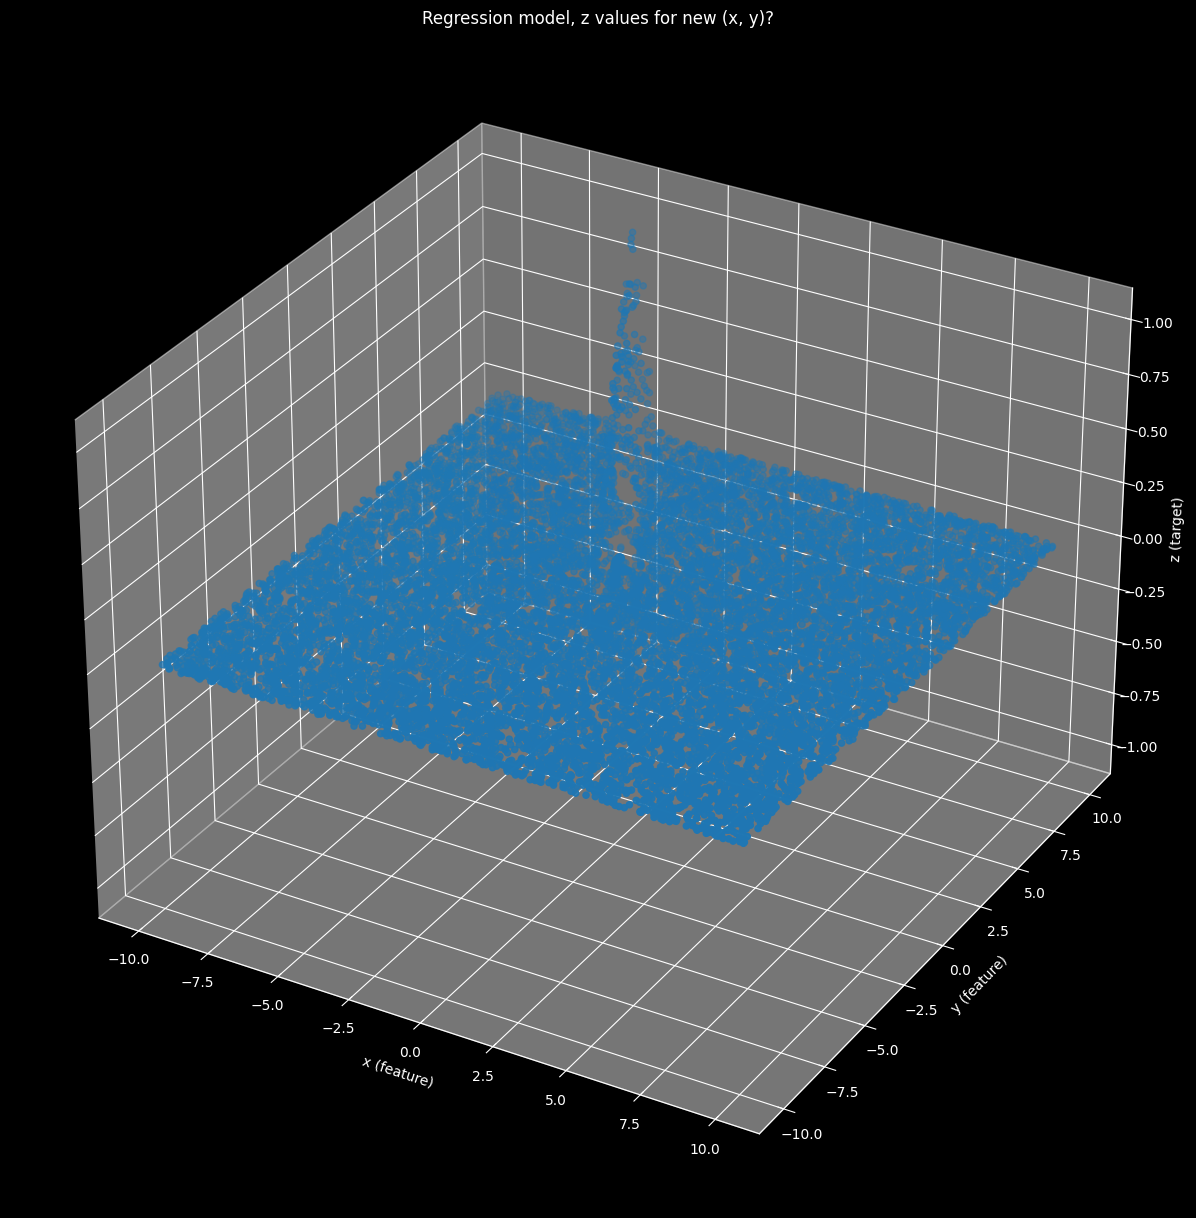

In [144]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams["figure.figsize"] = [12, 12]

#plt.style.use('_mpl-gallery')

# Make data
#np.random.seed(19680801)
#n = 100
#rng = np.random.default_rng()
#xs = rng.uniform(23, 32, n)
#ys = rng.uniform(0, 100, n)
#zs = rng.uniform(-50, -25, n)

# Plot
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
#fig = plt.figure()
#ax = Axes3D(fig)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.scatter(xy_train[:,0], xy_train[:,1], z_train, marker='o')

#ax.set(xticklabels=[],
   #    yticklabels=[],
    #   zticklabels=[])

#ax.scatter(x1, x2, ys, marker='o')
ax.set_title("Regression model, z values for new (x, y)?")
ax.set_xlabel("x (feature)")
ax.set_ylabel("y (feature)")
ax.set_zlabel("z (target)")

plt.show()

In [141]:
xy_train

array([[ -4.54015011,   2.13650063,  37.85413626],
       [ -6.9882564 ,  -4.46410622,  58.26556469],
       [  4.06368426,  -2.68865231, -33.88153561],
       ...,
       [  0.23013803,  -0.21223375,  -1.91880799],
       [  7.17398709,  -0.99760141, -59.81412025],
       [  4.90925241,   9.77470934, -40.93157825]])

In [43]:
xy_val

array([[-6.81115719, 46.39186233, -5.61563333, 31.53533767],
       [ 4.84515636, 23.47554012, -5.18802311, 26.91558376],
       [-7.45032835, 55.50739247,  5.5291111 , 30.57106956],
       ...,
       [-1.77905627,  3.1650412 , -9.27771064, 86.07591466],
       [-6.74559226, 45.50301487, -5.64670012, 31.88522222],
       [ 1.22872596,  1.50976749, -8.66819774, 75.13765215]])

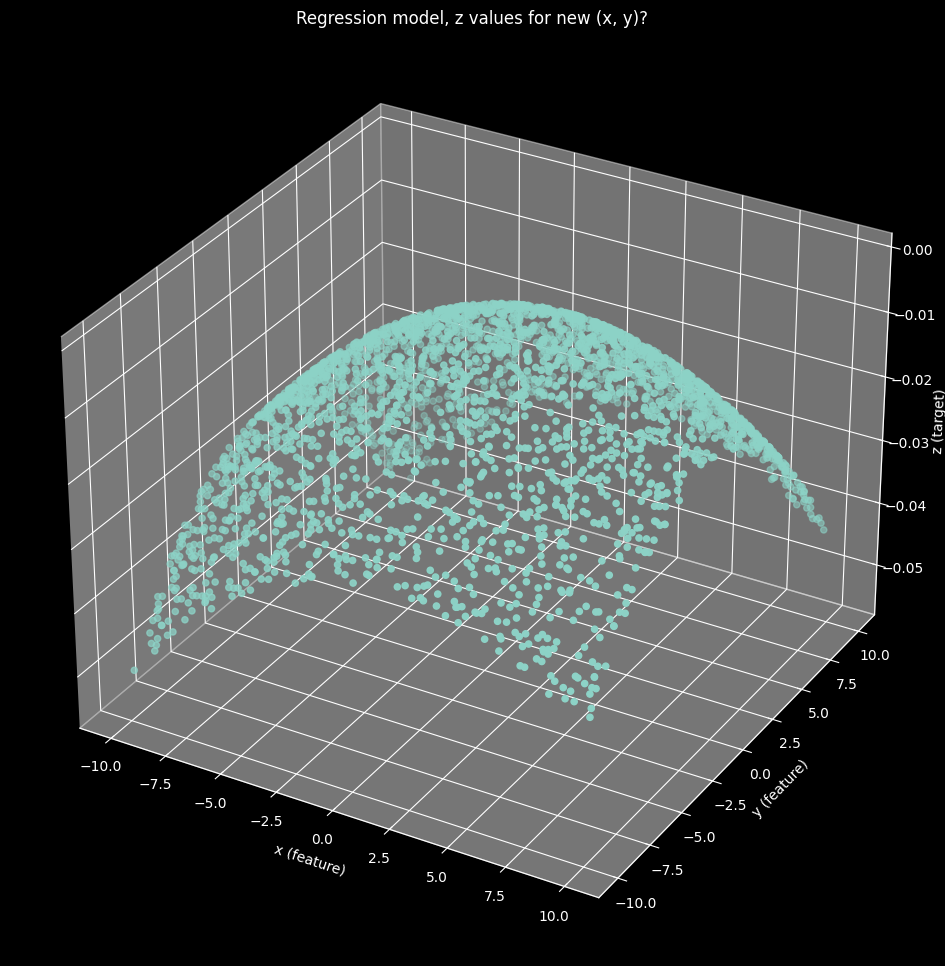

In [45]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams["figure.figsize"] = [12, 12]

#plt.style.use('_mpl-gallery')

# Make data
#np.random.seed(19680801)
#n = 100
#rng = np.random.default_rng()
#xs = rng.uniform(23, 32, n)
#ys = rng.uniform(0, 100, n)
#zs = rng.uniform(-50, -25, n)

# Plot
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
#fig = plt.figure()
#ax = Axes3D(fig)

z_res = -0.0024150116369128227 + 0.0006416605901904404 * xy_val[:,0] + (-0.0001850745757110417) * xy_val[:,0]   + (-0.0003436296246945858) * xy_val[:,2] + (-0.0002685207291506231) * xy_val[:,2] ** 2
#z_res = -0.0024150116369128227 + 0.0006416605901904404 * xy_test[:,0] + (-0.0001850745757110417) * xy_test[:,0] ** 2  + (-0.0003436296246945858) * xy_test[:,1] + (-0.0002685207291506231) * xy_test[:,1] ** 2

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
#ax.scatter(xy_val[:,0], xy_val[:,2], z_res)
ax.scatter(xy_train[:,0], xy_train[:,2], z_res)

ax.set_title("Regression model, z values for new (x, y)?")
ax.set_xlabel("x (feature)")
ax.set_ylabel("y (feature)")
ax.set_zlabel("z (target)")

plt.show()

In [38]:
import pandas as pd

array([[<Axes: title={'center': '0'}>]], dtype=object)

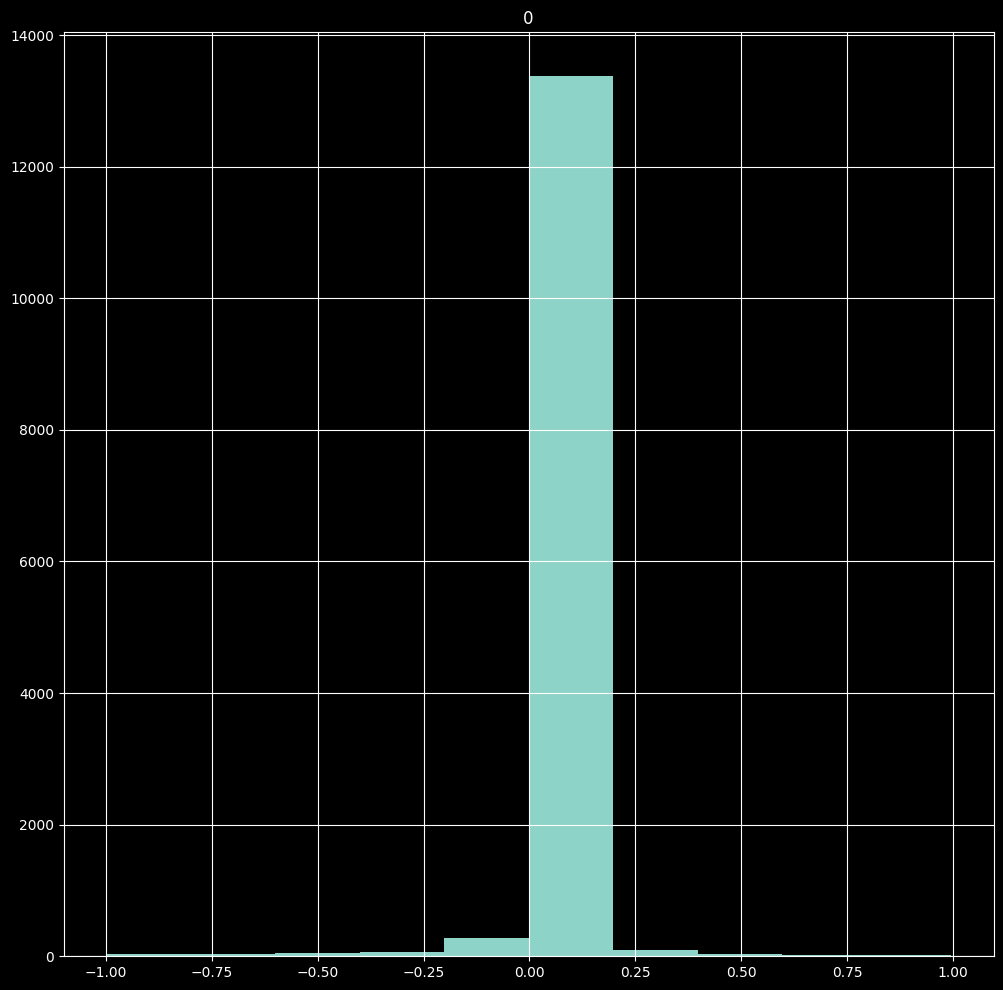

In [56]:

df1 = pd.DataFrame(z_train)
df1.hist()

array([[<Axes: title={'center': '0'}>]], dtype=object)

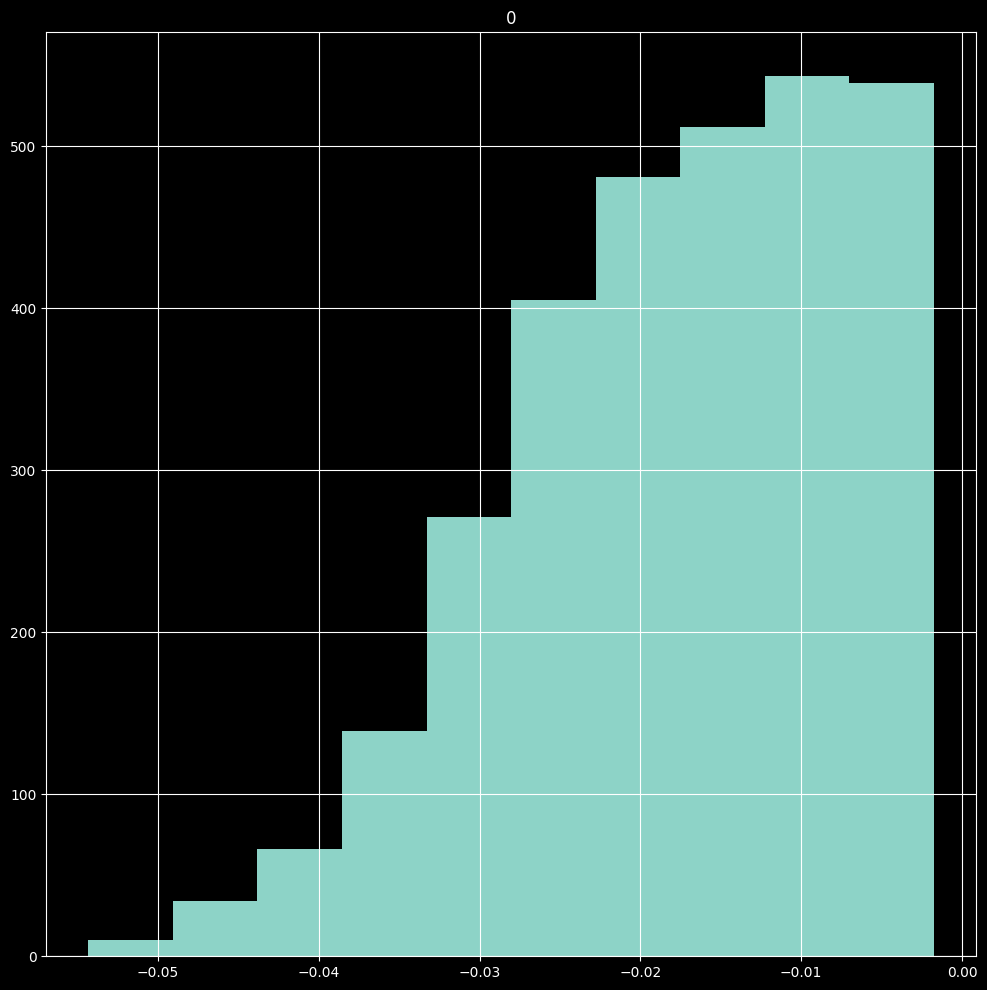

In [46]:

df2 = pd.DataFrame(z_res)
df2.hist()

In [165]:
z_res

array([ 0.70122008,  2.14858756, -3.68706533, ..., -1.73994802,
       -5.35906473, -4.44080467])

In [45]:
with torch.no_grad():
  torch.cuda.empty_cache()

In [4]:
import torch
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

In [4]:
from torchmetrics import Accuracy, F1Score, Precision, Recall
import torch.optim as optim
import torch.nn as nn

## 1. Создаем данные

In [5]:
x_np = np.random.uniform(-10,10,(20000,1))
y_np = np.random.uniform(-10,10,(20000,1))

In [27]:
x_np

array([[ 3.92938371],
       [-4.2772133 ],
       [-5.46297093],
       ...,
       [-1.09853322],
       [-4.45853312],
       [-4.40126025]])

In [6]:
z_np = np.sin(x_np * 2 ** y_np) * np.exp(-(2 * x_np + y_np)**2)

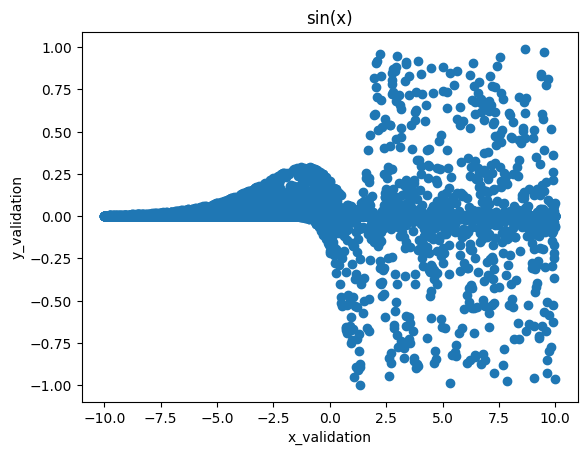

In [7]:
x_validation = torch.linspace(-10, 10, 100)
y_validation = np.sin(x_np)
plt.plot(y_np, z_np, 'o')
plt.title('sin(x)')
plt.xlabel('x_validation')
plt.ylabel('y_validation');

In [12]:
x_train, x_test_val, y_train, y_test_val = train_test_split(x_np, y_np,test_size=0.3,  random_state=42)

In [14]:
x_tmp, x_tmp_1, z_train, z_test_val = train_test_split(x_np,z_np,test_size=0.3,  random_state=42)

In [15]:
x_test, x_val, y_test, y_val = train_test_split(x_test_val, y_test_val, test_size=0.5,  random_state=42)

In [18]:
x_tmp2, x_tmp3, z_test, z_val = train_test_split(x_tmp_1, z_test_val, test_size=0.5,  random_state=42)

In [21]:
x_train_ts = torch.from_numpy(x_train)
y_train_ts = torch.from_numpy(y_train)
z_train_ts = torch.from_numpy(z_train)

In [22]:
x_test_ts = torch.from_numpy(x_test)
y_test_ts = torch.from_numpy(y_test)
z_test_ts = torch.from_numpy(z_test)

In [23]:
x_val_ts = torch.from_numpy(x_val)
y_val_ts = torch.from_numpy(y_val)
z_val_ts = torch.from_numpy(z_val)

In [38]:
# Подготавливаем входной тензор (x, x^2, x^3) который будет поступать в сеть:
p = torch.tensor([1.0, 2.0, 3.0])     # степени полинома
xx = x_train_ts.unsqueeze(-1).pow(p)     # возводим входной вектор x в степени p

# Определем модель из torch.nn котора состоит из одного линейного слоя с 1 нейронам
# каждый из трех нейронов моделирует собой один из коэффициентов полинома (а где же 4ый?)
#model = torch.nn.Sequential(
 #   torch.nn.Linear(3, 1),      # линейный слой из одного нейрона и трех входов (весов)
  #  torch.nn.Flatten(0, 1)      # представляем результат в виде вектора
#)

# Функция потерь MSE из torch.nn:
loss_fn = torch.nn.MSELoss(reduction='sum')

# Скорость обучения:
learning_rate = 1e-6


In [29]:
# Будем использовать оптимайзер RMSprop из torch.optim:
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

In [39]:
# Будем использовать оптимайзер RMSprop из torch.optim:
optimizer2 = torch.optim.RMSprop(sine_net.parameters(), lr=learning_rate)

In [31]:
xx

tensor([[[   9.1774,   84.2249,  772.9673]],

        [[  -9.2024,   84.6837, -779.2907]],

        [[  -4.9079,   24.0872, -118.2172]],

        ...,

        [[   1.4086,    1.9843,    2.7951]],

        [[   3.4787,   12.1015,   42.0977]],

        [[  -6.9431,   48.2072, -334.7095]]], dtype=torch.float64)

In [47]:
# Оптимизационный цикл (цикл обучения):
for t in range(2000):

    # Прямой проход: вычисляем предсказанный y пропуская вход xx через модель:
    y_pred = sine_net(xx)

    # Считаем ошибку (MSE) предскзанного y_pred и истинного y:
    loss = loss_fn(y_pred, z_test_ts)
    if t % 100 == 99:
        print(f'iter={t}, loss={loss.item()}')    # !!! loss.item()

    # Перед обратным проходом нам нужно занулить градиент для всех весов которые обновляет optimizer
    optimizer2.zero_grad()

    # Обратный проход (вычисляем градиенты для весов модели относительно loss):
    loss.backward()

    # Обновляем веса оптимайзером:
    optimizer.step()


# Мы можем обратиться к первому слою нашей модели как к первому элементу list:
linear_layer = model[0]

# Печатаем значения весов этого слоя (это и будут обученный коэффициенты искомого полинома):
print(f'Result: y = {linear_layer.bias.item()} + {linear_layer.weight[:, 0].item()} x + {linear_layer.weight[:, 1].item()} x^2 + {linear_layer.weight[:, 2].item()} x^3')

RuntimeError: mat1 and mat2 must have the same dtype, but got Double and Float

In [45]:
class SineNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(SineNet, self).__init__()
        self.fc1 = torch.nn.Linear(1, n_hidden_neurons)
        self.act1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 1)

    def forward(self, x):
       # print(type(self.weight))
       # print(type(self.bias))
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        return x

#     def forward(self, x):
#        # Convert input to tensor with data type int64
#        x_padded = pad_sequence(x, batch_first=True, padding_value=0)#.double()  # Ensure dtype matches model weights
        #embedded = self.embedding(x_padded)
        #embedded_avg = torch.mean(embedded, dim=1)
#        output = self.input(x_padded) **>>>>>>>> error here**
#        return torch.sigmoid(output)

sine_net = SineNet(3)

In [10]:
def predict(net, x, y):
    y_pred = net.forward(x)

    plt.plot(x.numpy(), y.numpy(), 'o', label='Groud truth')
    plt.plot(x.numpy(), y_pred.data.numpy(), 'o', c='r', label='Prediction');
    plt.legend(loc='upper left')
    plt.xlabel('$x$')
    plt.ylabel('$y$')


In [ ]:

predict(sine_net, x_validation, y_validation)

In [8]:
optimizer = torch.optim.Adam(sine_net.parameters(), lr=0.01)

NameError: name 'sine_net' is not defined

In [5]:
x_np = np.linspace(-10, 10, 20000)
y_np = np.linspace(-10, 10, 20000)

In [6]:
#sin(x + 2*y)exp(-(2x + y)^2)
z_np = np.sin(x_np * 2 ** y_np) * np.exp(-(2 * x_np + y_np)**2)

In [7]:
x_dt =pd.DataFrame(x_np, columns=['X'])


In [ ]:
x_dt.head()

,X
0,-10.000
1,-9.999
2,-9.998
3,-9.997
4,-9.996


In [ ]:
y_dt =pd.DataFrame(y_np, columns=['Y'])

In [ ]:
y_dt.head()

,Y
0,-10.000
1,-9.999
2,-9.998
3,-9.997
4,-9.996


In [ ]:
z_dt =pd.DataFrame(z_np, columns=['Z'])

In [ ]:
xy_dt = x_dt.join(y_dt)

## Эксперимент 1

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [9]:
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
x_train_1, x_test_1, y_train_1, x_test_1 = train_test_split(x_dt,y_dt,test_size=0.3,  random_state=42)

In [ ]:
x_train_1, x_test_1, y_train_1, x_test_1 = train_test_split(x_dt,y_dt,test_size=0.3,  random_state=42)

In [ ]:


X = np.hstack([x_dt, y_dt])
lin_reg = LinearRegression()
lin_reg.fit(X, z_dt)
print("Intercept: {:.4f} \nSlopes: {}\n".format(lin_reg.intercept_[0], lin_reg.coef_[0]))
z_pred = lin_reg.predict(X)
print("\nMAE: {:.4f}".format(mean_absolute_error(z_pred, z_dt)))

Intercept: 0.0010 
Slopes: [2.44982936e-05 2.44982936e-05]


MAE: 0.0065


In [ ]:
def plane(x1, x2):
    return 0.0010  + 2.44982936e-05 * x1  + 2.44982936e-05 * x2

In [ ]:
X

array([[-10.        , -10.        ],
       [ -9.99899995,  -9.99899995],
       [ -9.9979999 ,  -9.9979999 ],
       ...,
       [  9.9979999 ,   9.9979999 ],
       [  9.99899995,   9.99899995],
       [ 10.        ,  10.        ]])

In [ ]:
fig=plt.figure(figsize=(20, 10))
ax = Axes3D(fig)

#x1_surfs = np.arange(0, 2.5, 0.5)
#x2_surfs = np.arange(0, 5.0, 1)
#x1_surf, x2_surf = np.meshgrid(x1_surfs, x2_surfs)

#zs_pred = np.array([lin_reg.predict(np.array([[x_i, y_i]])) for x_i, y_i in zip(np.ravel(x1_surf), np.ravel(x2_surf))])
#z_predicted = zs_pred.reshape(x1_surf.shape)
#ax.plot_surface(x1_surf, x2_surf, z_predicted, alpha=0.2, color='blue')
ax.scatter(x_np, y_np, z_np, marker='o')

ax.set_title("Linear Regression ")
ax.set_xlabel("x (feature)")
ax.set_ylabel("y (feature)")
ax.set_zlabel("z (target)")

plt.show()

<Figure size 2000x1000 with 0 Axes>

In [3]:
import numpy as np
import numpy.linalg as la
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

%matplotlib inline
np.random.seed(123)

import warnings
warnings.filterwarnings("ignore")

In [1]:
plt.rcParams["figure.figsize"] = [9, 6]
fig=plt.figure()
ax = Axes3D(fig)

x1 = 2 * np.random.rand(100, 1)
x2 = 5 * np.random.rand(100, 1)

# y = 4 + 3*x_1 + 1*x_2
y = 4 + 3 * x1 + 1* x2 + np.random.randn(100, 1)

ax.scatter(x1, x2, y, marker='o')
ax.set_title("Regression problem \n What is y value for new (x1, x2)?")
ax.set_xlabel("x1 (feature)")
ax.set_ylabel("x2 (feature)")
ax.set_zlabel("y (target)")
plt.show();

NameError: name 'plt' is not defined

## 2. Делим данные train, test, val.

In [ ]:
XY_train, XY_test_val, Z_train, Z_test_val = train_test_split(xy_dt,z_dt,test_size=0.3,  random_state=42)

In [ ]:
XY_train.count()

X    14000
Y    14000
dtype: int64

In [ ]:
XY_test, XY_val, Z_test, Z_val = train_test_split(XY_test_val,Z_test_val,test_size=0.5,  random_state=42)

In [ ]:
xy_train = torch.from_numpy(XY_train.values).float()
z_train = torch.from_numpy(Z_train.values).float()

In [ ]:
xy_test = torch.from_numpy(XY_test.values).float()
z_test = torch.from_numpy(Z_test.values).float()
xy_val = torch.from_numpy(XY_val.values).float()
z_val = torch.from_numpy(Z_val.values).float()

In [ ]:
x_train = torch.from_numpy(XY_train.X.values).float()
y_train = torch.from_numpy(XY_train.Y.values).float()
z_train = torch.from_numpy(Z_train.values).float()

ValueError: Found input variables with inconsistent numbers of samples: [20000, 3000]

In [ ]:
# Metrics
accuracy = Accuracy(task="binary")
f1_score = F1Score(task="binary")
precision = Precision(task="binary")
recall = Recall(task="binary")

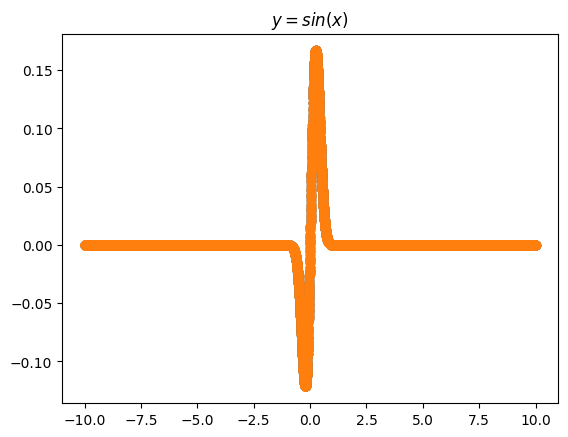

In [ ]:
plt.plot(xy_train.numpy(), z_train.numpy(), 'o')
plt.title('$y = sin(x)$');

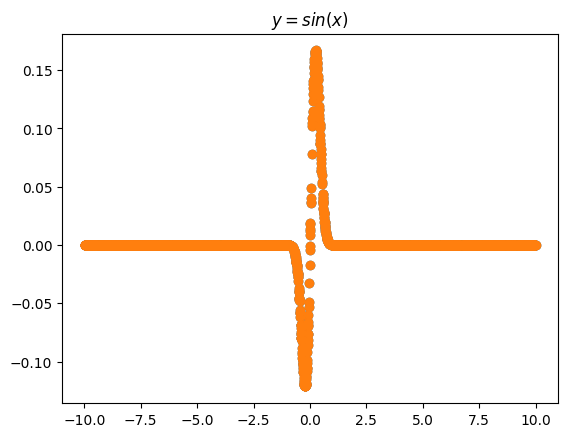

In [ ]:
plt.plot(xy_test.numpy(), z_test.numpy(), 'o')
plt.title('$y = sin(x)$');

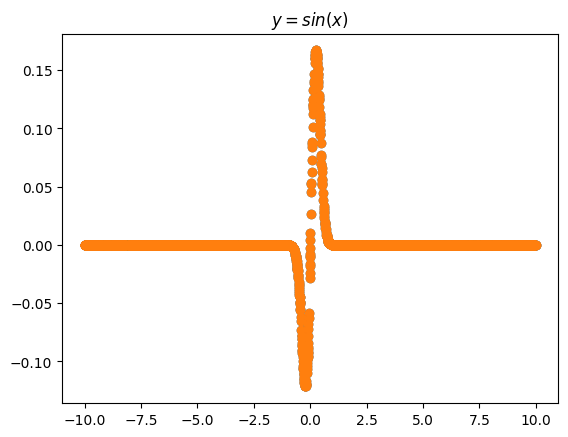

In [ ]:
plt.plot(xy_val.numpy(), z_val.numpy(), 'o')
plt.title('$y = sin(x)$');

In [ ]:
def lin_reg_model(X, w, Y, h, b):
    return X @ w.t() + Y @ h.t() + b

In [ ]:
def mse(true, predicted):
    return ((true - predicted) ** 2).sum() / true.numel()

In [ ]:
# по мотивами Kaiming initialization
weight_x = torch.randn(z_train.shape[1], x_train.shape[1]) / math.sqrt(2 / z_train.shape[1])
weight_y = torch.randn(z_train.shape[1], y_train.shape[1]) / math.sqrt(2 / z_train.shape[1])
bias = torch.zeros(z_train.shape[1])
# начинаем записывать историю вычислений
weight_x.requires_grad_(True)
weight_y.requires_grad_(True)
bias.requires_grad_(True);

IndexError: tuple index out of range

In [ ]:
learning_rate = 0.01
epochs = 10000

for epoch in range(epochs):
    # forward pass — вычисляем функцию потерь
    predictions = lin_reg_model(x_train, weight_x, y_train, weight_y, bias)
    loss = mse(predictions, z_train)
    # backward paass — вычисляем градиент
    loss.backward()
    # вычитаем производные из параметров
    # записывать историю вычислений уже не нужно (no_grad)
    with torch.no_grad():
        weight_x -= weight_x.grad * learning_rate
        weight_y -= weight_y.grad * learning_rate
        bias -= bias.grad * learning_rate
        # обнуляем производные
        weight_x.grad.zero_()
        weight_y.grad.zero_()
        bias.grad.zero_()
    # выводим значение фукнции потерь каждые 2000 повторов
    if (epoch + 1) % (epochs / 10) == 0:
        print('epoch {}, loss {}'.format(epoch, loss.item()))

In [ ]:
# Подготавливаем входной тензор (x, x^2, x^3) который будет поступать в сеть:
p = torch.tensor([1, 2, 3])     # степени полинома
xx = xy_test.unsqueeze(-1).pow(p)     # возводим входной вектор x в степени p
##xy_test.unsqueeze(-1)
# Инициализируем коэффициенты нашего полинома случайными значениями (выполняют роль весов модели):
a = torch.randn((),  dtype=torch.float32)
b = torch.randn((),  dtype=torch.float32)
c = torch.randn((),  dtype=torch.float32)
d = torch.randn((),  dtype=torch.float32)
e = torch.randn((),  dtype=torch.float32)
s = torch.randn((),  dtype=torch.float32)

## 3. Модель

In [ ]:
class MyNet(torch.nn.Module):
    def __init__(self, input_shape, n_hidden_neurons,  output_shape):
        super(MyNet, self).__init__()
        self.fc1 = torch.nn.Linear(input_shape, n_hidden_neurons)
        self.act1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, output_shape)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        return x



In [ ]:
myNet = MyNet(2, 3, 1)

In [ ]:
# Определем модель из torch.nn котора состоит из одного линейного слоя с 3 нейронами
# каждый из трех нейронов моделирует собой один из коэффициентов полинома (а где же 4ый?)
myNet = torch.nn.Sequential(
    torch.nn.Linear(3, 1),      # линейный слой из одного нейрона и трех входов (весов)
    torch.nn.Flatten(0, 1)      # представляем результат в виде вектора
)


In [ ]:
# Функция потерь MSE из torch.nn:
loss_fn = torch.nn.MSELoss(reduction='sum')

# Скорость обучения:
learning_rate = 1e-3

# Будем использовать оптимайзер RMSprop из torch.optim:
optimizer = torch.optim.RMSprop(myNet.parameters(), lr=learning_rate)


In [ ]:
xx.size()

torch.Size([3000, 2, 3])

In [ ]:


# Оптимизационный цикл (цикл обучения):
for t in range(2000):

    # Прямой проход: вычисляем предсказанный y
     y_pred = a + b * x + c * x ** 2 + d * x ** 3 + e * x * y ** 2 + s * (x **2) * y

    # Считаем ошибку (MSE) предскзанного y_pred и истинного y:
    loss = (y_pred - z_test).pow(2).sum().item()
    if t % 100 == 99:
        print(f'iter={t}, loss={loss}')

    # Обратный проход (вычисляем градиенты для a, b, c, d относительно loss):
    grad_y_pred = 2.0 * (y_pred - z_test)
    grad_a = grad_y_pred.sum()
    grad_b = (grad_y_pred * xy_test).sum()
    grad_c = (grad_y_pred * xy_test ** 2).sum()
    grad_d = (grad_y_pred * xy_test ** 3).sum()
    grad_e = (grad_y_pred * xy_test ** 2).sum()
    grad_s = (grad_y_pred * xy_test ** 2).sum()

    # Обновляем коэффициенты полинома (веса) с учетом расчитанного градиента:
    a -= learning_rate * grad_a
    b -= learning_rate * grad_b
    c -= learning_rate * grad_c
    d -= learning_rate * grad_d


print(f'Result: y = {a.item()} + {b.item()} x + {c.item()} x^2 + {d.item()} x^3')

IndentationError: unindent does not match any outer indentation level (<string>, line 8)

In [ ]:
# Оптимизационный цикл (цикл обучения):
for t in range(2000):

    # Прямой проход: вычисляем предсказанный y пропуская вход xx через модель:
    #y_pred = myNet(xx)
    y_pred = a + b * x + c * x ** 2 + d * x ** 3 + e * x * y ** 2 + c * (x **2) * y
    print(y_pred.size())

    # Считаем ошибку (MSE) предскзанного y_pred и истинного y:
    loss = loss_fn(y_pred, z_test)
    if t % 100 == 99:
        print(f'iter={t}, loss={loss.item()}')    # !!! loss.item()

    # Перед обратным проходом нам нужно занулить градиент для всех весов которые обновляет optimizer
    optimizer.zero_grad()

    # Обратный проход (вычисляем градиенты для весов модели относительно loss):
    loss.backward()

    # Обновляем веса оптимайзером:
    optimizer.step()


# Мы можем обратиться к первому слою нашей модели как к первому элементу list:
linear_layer = model[0]

# Печатаем значения весов этого слоя (это и будут обученный коэффициенты искомого полинома):
print(f'Result: y = {linear_layer.bias.item()} + {linear_layer.weight[:, 0].item()} x + {linear_layer.weight[:, 1].item()} x^2 + {linear_layer.weight[:, 2].item()} x^3')

torch.Size([20000])


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

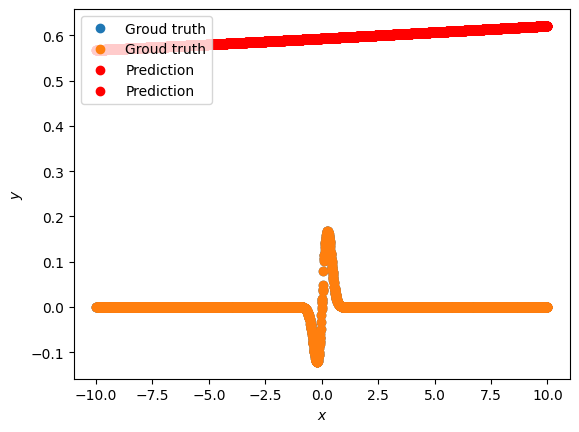

In [ ]:
def predict(net, x, y):
    y_pred = net.forward(x)

    plt.plot(x.numpy(), y.numpy(), 'o', label='Groud truth')
    plt.plot(x.numpy(), y_pred.data.numpy(), 'o', c='r', label='Prediction');
    plt.legend(loc='upper left')
    plt.xlabel('$x$')
    plt.ylabel('$y$')

predict(myNet, xy_test, z_test)

In [ ]:
optimizer = torch.optim.Adam(my_net.parameters(), lr=0.01)

In [ ]:
def loss(pred, target):
    squares = (pred - target) ** 2
    return squares.mean()

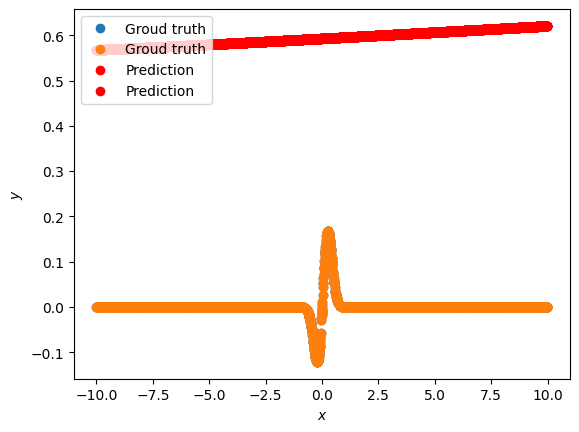

In [ ]:
for epoch_index in range(2000):
    optimizer.zero_grad()

    z_pred = myNet.forward(xy_train)
    loss_val = loss(z_pred, z_train)

    loss_val.backward()

    optimizer.step()

predict(myNet, xy_val, z_val)

In [ ]:
def dataset_to_loader(X_train, y_train, X_test, y_test, batch_size):

    torch.manual_seed(42)
    """
    Function will return two objects train, test DataLoaders
    needs a batch_size
    """

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset,batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

    return train_loader, test_loader

In [ ]:
torch.manual_seed(42)

deep_model_no_manipulation = MyNet(
    input_shape=3,
    n_hidden_neurons=3,
    output_shape=1
)
deep_model_no_manipulation

MyNet(
  (fc1): Linear(in_features=3, out_features=3, bias=True)
  (act1): Sigmoid()
  (fc2): Linear(in_features=3, out_features=1, bias=True)
)

## 4. Оптимизатор

In [ ]:
optimizer = torch.optim.Adam(my_net.parameters(), lr=0.01)

## 5. Loss функция

In [ ]:
loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(params=deep_model_no_manipulation.parameters(), lr=0.01)

In [ ]:
#def loss(pred, target):
#    squares = (pred - target) ** 2
#    return squares.sum()

In [ ]:
#tmp = torch.Tensor([1,2,3])

## 6. Предсказание

In [ ]:
def train_model(model,X_train, y_train, X_test, y_test, epochs, batch_size):

    ##model.to(device)

    train_dataloader , test_dataloader = dataset_to_loader(X_train, y_train, X_test, y_test, batch_size)

    results = []

    for epoch in range(epochs):

        accuracy.reset()
        f1_score.reset()
        precision.reset()
        recall.reset()
        train_loss = 0

        preds_per_epoch_accumulated = [] # Probabilities
        labels_per_epoch_accumulated = []

        model.train()

        for X_train, y_train in train_dataloader:

            #X_train, y_train = X_train.to(device), y_train.to(device)
            X_train, y_train = X_train, y_train
            y_train = y_train.unsqueeze(1) #ValueError: Target size (torch.Size([32])) must be the same as input size (torch.Size([32, 1])) to fix that

            predictions = model(X_train)

            loss = loss_function(predictions, y_train) # No sigmoid her BCEWithLogitsLoss takes care of taht

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            # Calcualte AUC PR
            preds_sigmoid = torch.sigmoid(predictions).detach().cpu().numpy() # Probabilities
            labels = y_train.detach().cpu().numpy() # labels from GPU/tensor to nupy so i can use my_auc_pr function

            preds_per_epoch_accumulated.extend(preds_sigmoid)
            labels_per_epoch_accumulated.extend(labels)

            predicted_class = (preds_sigmoid >= 0.5).astype(int)

            # Metrics update
            train_loss += loss.item()
            accuracy.update(torch.tensor(predicted_class), y_train)
            f1_score.update(torch.tensor(predicted_class), y_train)
            precision.update(torch.tensor(predicted_class), y_train)
            recall.update(torch.tensor(predicted_class), y_train)

        accuracy_ = accuracy.compute().item()
        f1_score_ = f1_score.compute().item()
        precision_ = precision.compute().item()
        recall_ = recall.compute().item()

        # Calcualte AUC PR

        auc_pr_ = my_auc_pr(labels_per_epoch_accumulated,preds_per_epoch_accumulated) # calculate auc_pr after each epoch

        epoch_results = {
            "epoch" : epoch + 1,
            "loss" : train_loss/len(train_dataloader),
            "accuracy" : accuracy_,
            "f1_score" : f1_score_,
            "precision" : precision_,
            "recall" : recall_,
            "auc pr" : auc_pr_
        }

        if epoch % 10 == 0 or epoch == epochs - 1:
            print(f"Epoch: {epoch + 1}, Loss: {epoch_results['loss']:.5f}, "
                  f"Accuracy: {accuracy_:.4f}, F1: {f1_score_:.4f}, "
                  f"Precision: {precision_:.4f}, Recall: {recall_:.4f}, AUC-PR: {auc_pr_:.4f}")

        results.append(epoch_results)

    return results

In [ ]:
# For time sake  I will only test to 50 epochs, in the future i may decide to add earliy stopping to prevent model from overfitting

deep_model_no_manipulation_results = train_model(deep_model_no_manipulation, xy_train, z_train, xy_test,z_test,1000,1)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x2 and 3x3)

In [ ]:
def predict(net, x, y):
    y_pred = net.forward(x)

    plt.plot(x.numpy(), y.numpy(), 'o', label='Groud truth')
    plt.plot(x.numpy(), y_pred.data.numpy(), 'o', c='r', label='Prediction');
    plt.legend(loc='upper left')
    plt.xlabel('$x$')
    plt.ylabel('$y$')

predict(my_net, xy_train, z_train)

RuntimeError: mat1 and mat2 must have the same dtype, but got Double and Float

In [ ]:
from torch.utils.data import TensorDataset